In [1]:
import numpy as np
import pandas as pd
from pandas import read_excel
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerLine2D

# Models required for the project
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX

# To calculate RMSE metric for each model
from sklearn.metrics import mean_squared_error
from math import sqrt

# Allows us to show more than one ouput in the same cell of the jupyter notebook
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'


# Importing the Energy.xlsx dataset

In [2]:
df1 = pd.read_excel("Energy.xlsx", sheet_name=0, header=0,index_col=False, keep_default_na=True)

# Shape, Head and Tail of the dataset

In [3]:
df1.shape
df1.head()
df1.tail()

(105120, 3)

,Time,Solar Power (MW),Windspeed (mph)
0,2019-01-01 00:00:00,0.0,17.939
1,2019-01-01 00:05:00,0.0,NaN
2,2019-01-01 00:10:00,0.0,7.580
3,2019-01-01 00:15:00,0.0,NaN
4,2019-01-01 00:20:00,0.0,4.872


,Time,Solar Power (MW),Windspeed (mph)
105115,2019-12-31 23:35:00,0.0,NaN
105116,2019-12-31 23:40:00,0.0,0.0
105117,2019-12-31 23:45:00,0.0,NaN
105118,2019-12-31 23:50:00,0.0,0.0
105119,2019-12-31 23:55:00,0.0,NaN


# Checking For Missing Values

In [4]:
df1.isna().sum()

Time                    0
Solar Power (MW)        0
Windspeed (mph)     52560
dtype: int64

We can see that we have quite a few missing values in windspeed column, let us see what percentage of the total values is missing. 

In [5]:
percent_missing = (df1.isna().sum()[2]/df1.shape[0])*100
print(str(percent_missing) + "% of values in Windspeed (mph) column is missing.")

50.0% of values in Windspeed (mph) column is missing.


Let us take a look at the windspeed column once again

In [6]:
df1["Windspeed (mph)"]

0         17.939
1            NaN
2          7.580
3            NaN
4          4.872
           ...  
105115       NaN
105116     0.000
105117       NaN
105118     0.000
105119       NaN
Name: Windspeed (mph), Length: 105120, dtype: float64

The performance of our model will heavily detoriate if we use these missing values and train it.
If we try and extrapolate the mean of the windspeed column to these missing values, there will be heavy biases present in our model. Since we have no way of extrapolating these values effectively I have chosen to get rid of all the rows that have missing values of windspeed in them. 

We make a copy of the original dataset for just in case cases where if something goes wrong and work on the copy of the dataset. 

In [7]:
df2 = df1.copy()

In [8]:
# Removing all values with missing values
df2 = df2.dropna()
df2.head

<bound method NDFrame.head of                       Time  Solar Power (MW)  Windspeed (mph)
0      2019-01-01 00:00:00               0.0           17.939
2      2019-01-01 00:10:00               0.0            7.580
4      2019-01-01 00:20:00               0.0            4.872
6      2019-01-01 00:30:00               0.0            0.557
8      2019-01-01 00:40:00               0.0            0.000
...                    ...               ...              ...
105110 2019-12-31 23:10:00               0.0            0.000
105112 2019-12-31 23:20:00               0.0            0.000
105114 2019-12-31 23:30:00               0.0            0.000
105116 2019-12-31 23:40:00               0.0            0.000
105118 2019-12-31 23:50:00               0.0            0.000

[52560 rows x 3 columns]>

#### Resetting the index

In [9]:
df2 = df2.reset_index(drop = True)
df2

,Time,Solar Power (MW),Windspeed (mph)
0,2019-01-01 00:00:00,0.0,17.939
1,2019-01-01 00:10:00,0.0,7.580
2,2019-01-01 00:20:00,0.0,4.872
3,2019-01-01 00:30:00,0.0,0.557
4,2019-01-01 00:40:00,0.0,0.000
...,...,...,...
52555,2019-12-31 23:10:00,0.0,0.000
52556,2019-12-31 23:20:00,0.0,0.000
52557,2019-12-31 23:30:00,0.0,0.000
52558,2019-12-31 23:40:00,0.0,0.000


Let us look for missing values and the shape of the dataset now. 

In [10]:
# Checking for missing values again
df2.isna().sum()

# Shape of the dataset
df2.shape

Time                0
Solar Power (MW)    0
Windspeed (mph)     0
dtype: int64

(52560, 3)

Let us take a look at the class of each column in the dataframe. 

In [11]:
# Looking at column types
df2.info()

# Looking at descriptive statistics of the numerical columns in the datasets
df2.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52560 entries, 0 to 52559
Data columns (total 3 columns):
Time                52560 non-null datetime64[ns]
Solar Power (MW)    52560 non-null float64
Windspeed (mph)     52560 non-null float64
dtypes: datetime64[ns](1), float64(2)
memory usage: 1.2 MB


,Solar Power (MW),Windspeed (mph)
count,52560.000000,52560.000000
mean,0.735283,4.338170
std,1.046398,9.183646
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,1.460000,1.826000
max,3.840000,30.000000


Changing the names of the columns in the dataset for convenience

In [12]:
# Renaming columns for ease of referring in the future
df2 = df2.rename(columns = {"Time":"time","Solar Power (MW)":"solar","Windspeed (mph)":"wind"})
df2



,time,solar,wind
0,2019-01-01 00:00:00,0.0,17.939
1,2019-01-01 00:10:00,0.0,7.580
2,2019-01-01 00:20:00,0.0,4.872
3,2019-01-01 00:30:00,0.0,0.557
4,2019-01-01 00:40:00,0.0,0.000
...,...,...,...
52555,2019-12-31 23:10:00,0.0,0.000
52556,2019-12-31 23:20:00,0.0,0.000
52557,2019-12-31 23:30:00,0.0,0.000
52558,2019-12-31 23:40:00,0.0,0.000


Let us take a look at the distribution of the columns by using histogram.

(array([38643.,  2476.,  1309.,   830.,   540.,   540.,   433.,   332.,
          303.,   273.,   265.,   243.,   258.,   255.,   246.,   254.,
          291.,   295.,   700.,  4074.]),
 array([ 0. ,  1.5,  3. ,  4.5,  6. ,  7.5,  9. , 10.5, 12. , 13.5, 15. ,
        16.5, 18. , 19.5, 21. , 22.5, 24. , 25.5, 27. , 28.5, 30. ]),
 <a list of 20 Patch objects>)

Text(0.5, 1.0, 'Windpseed Histogram')

Text(0.5, 0, 'Windspeed (mph)')

Text(0, 0.5, 'Count')

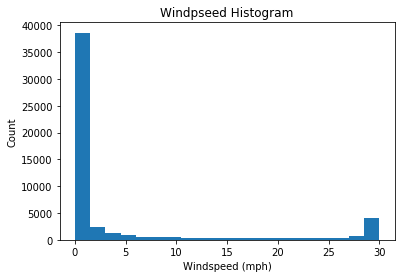

In [13]:
# Creating Histogram of windspeeds in the dataset
plt.hist(df2["wind"],bins=20)

plt.title("Windpseed Histogram")
plt.xlabel('Windspeed (mph)')
plt.ylabel('Count')

plt.show()



(array([31050.,   568.,  1636.,  1615.,  1353.,  1308.,  1195.,  1182.,
         1250.,  1227.,  1393.,  1420.,  1578.,  1639.,  1416.,  1239.,
          871.,   407.,   160.,    53.]),
 array([0.   , 0.192, 0.384, 0.576, 0.768, 0.96 , 1.152, 1.344, 1.536,
        1.728, 1.92 , 2.112, 2.304, 2.496, 2.688, 2.88 , 3.072, 3.264,
        3.456, 3.648, 3.84 ]),
 <a list of 20 Patch objects>)

Text(0.5, 1.0, 'Solar Power Histogram')

Text(0.5, 0, 'Solar Power (MW)')

Text(0, 0.5, 'Count')

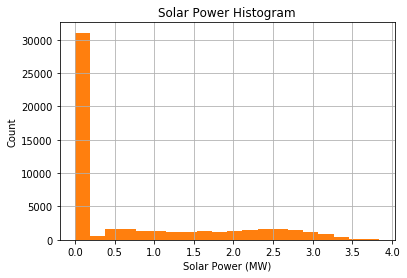

In [14]:
# Creating Histogram of solar power in the dataset
df2["solar"].hist(bins=20)

plt.hist(df2["solar"],bins=20)

plt.title("Solar Power Histogram")
plt.xlabel('Solar Power (MW)')
plt.ylabel('Count')

plt.show()


We can see that we have a lot of values that are 0 in both the columns. For now we will keep the values as it is. 

Text(0.5, 1.0, 'Mean values of Solar and Wind per hour')

Text(0.5, 0, 'Hour of Day')

Text(0, 0.5, 'Solar/Windspeed value')

<function matplotlib.pyplot.show(*args, **kw)>

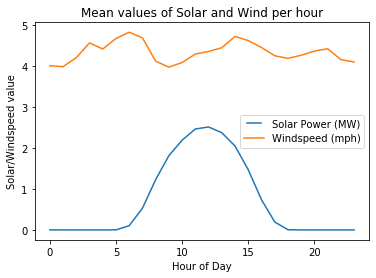

In [15]:
# Creating line plot for looking at mean values per hour for both windspeed
# and solar power
solar_mean, = plt.plot(df2.groupby(df2.time.dt.hour).solar.mean(), Label = 'Solar Power (MW)')
wind_mean, = plt.plot(df2.groupby(df2.time.dt.hour).wind.mean(), Label = 'Windspeed (mph)')

plt.title("Mean values of Solar and Wind per hour")
plt.xlabel("Hour of Day")
plt.ylabel("Solar/Windspeed value")

plt.legend(handler_map = {solar_mean:HandlerLine2D(numpoints=4)})
plt.show


Text(0.5, 1.0, 'Mean values of windspeed per hour of the day')

Text(0.5, 0, 'Hour of Day')

Text(0, 0.5, 'Windspeed value')

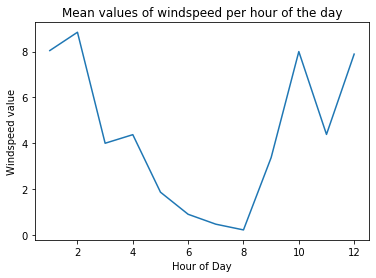

In [16]:
# Creating line plot for looking at mean values of windspeed per hour
# throughout the year. 
plt.plot(df2.groupby(df2.time.dt.month).wind.mean(), Label = 'Windspeed (mph)')

plt.title('Mean values of windspeed per hour of the day')
plt.xlabel("Hour of Day")
plt.ylabel("Windspeed value")
plt.show()



Text(0.5, 1.0, 'Mean values of solar power per hour of the day')

Text(0.5, 0, 'Hour of Day')

Text(0, 0.5, 'Solar Power value')

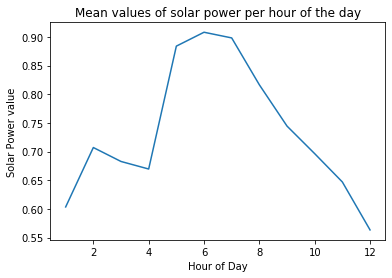

In [17]:
# Creating line plot for looking at mean values of solar power generated
# per hour throughout the year. 

plt.plot(df2.groupby(df2.time.dt.month).solar.mean(), Label = 'Solar Power (MW)')
plt.title('Mean values of solar power per hour of the day')
plt.xlabel("Hour of Day")
plt.ylabel("Solar Power value")
plt.show()



Text(0.5, 1.0, 'Windspeed Values for every 15 minutes')

Text(0.5, 0, 'Minute of every Day for the year')

Text(0, 0.5, 'Windspeed value')

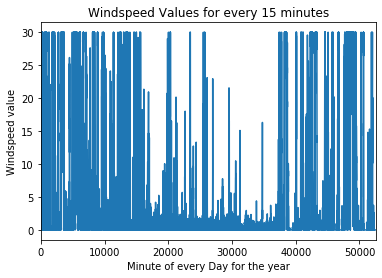

In [18]:
# Creating line plot of all the values of windspeed
# recorded every 10 minutes throughout the whole year

df2.wind.plot()
plt.title('Windspeed Values for every 15 minutes')
plt.xlabel("Minute of every Day for the year")
plt.ylabel("Windspeed value")
plt.show()

Text(0.5, 1.0, 'Solar power Values for every 15 minutes')

Text(0.5, 0, 'Minute of every Day for the year')

Text(0, 0.5, 'Solar Power value')

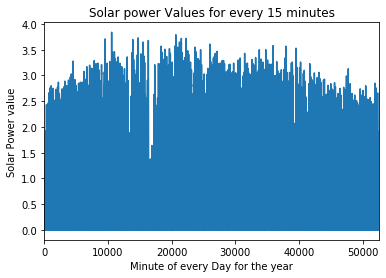

In [19]:
# Creating line plot of all the values of Solar power 
# recorded every 10 minutes throughout the whole year

df2.solar.plot()

plt.title('Solar power Values for every 15 minutes')
plt.xlabel("Minute of every Day for the year")
plt.ylabel("Solar Power value")
plt.show()




In [20]:
df3 = df2[['time','solar']]
column_titles = ["solar","time"]
df4 = df3.reindex(columns=column_titles)

,time,solar
0,2019-01-01 00:00:00,0.0
1,2019-01-01 00:10:00,0.0
2,2019-01-01 00:20:00,0.0
3,2019-01-01 00:30:00,0.0
4,2019-01-01 00:40:00,0.0
...,...,...
52555,2019-12-31 23:10:00,0.0
52556,2019-12-31 23:20:00,0.0
52557,2019-12-31 23:30:00,0.0
52558,2019-12-31 23:40:00,0.0


,solar,time
0,0.0,2019-01-01 00:00:00
1,0.0,2019-01-01 00:10:00
2,0.0,2019-01-01 00:20:00
3,0.0,2019-01-01 00:30:00
4,0.0,2019-01-01 00:40:00
...,...,...
52555,0.0,2019-12-31 23:10:00
52556,0.0,2019-12-31 23:20:00
52557,0.0,2019-12-31 23:30:00
52558,0.0,2019-12-31 23:40:00


In [21]:
# Creating dataframes to visualize the mean solar power and windspeed
# value per day throughout the year
df4['Month'] = df4['time'].dt.strftime('%b')
df4['Day'] = df4['time'].dt.day
df4 = df4.set_index(['Month','Day']).mean(level=[0,1]).reset_index()

In [22]:
df5 = df2[['time','wind']]
column_titles = ["wind","time"]
df6 = df5.reindex(columns=column_titles)
df6

,wind,time
0,17.939,2019-01-01 00:00:00
1,7.580,2019-01-01 00:10:00
2,4.872,2019-01-01 00:20:00
3,0.557,2019-01-01 00:30:00
4,0.000,2019-01-01 00:40:00
...,...,...
52555,0.000,2019-12-31 23:10:00
52556,0.000,2019-12-31 23:20:00
52557,0.000,2019-12-31 23:30:00
52558,0.000,2019-12-31 23:40:00


In [23]:
df6['Month'] = df6['time'].dt.strftime('%b')
df6['Day'] = df6['time'].dt.day
df6 = df6.set_index(['Month','Day']).mean(level=[0,1]).reset_index()

,Month,Day,solar
0,Jan,1,0.040694
1,Jan,2,0.324306
2,Jan,3,0.514097
3,Jan,4,0.476528
4,Jan,5,0.572778
...,...,...,...
360,Dec,27,0.587014
361,Dec,28,0.703472
362,Dec,29,0.660764
363,Dec,30,0.660486


Text(0.5, 1.0, 'Mean Solar Power value per day of the year')

Text(0.5, 0, 'Time')

Text(0, 0.5, 'Solar Power (MW) value')

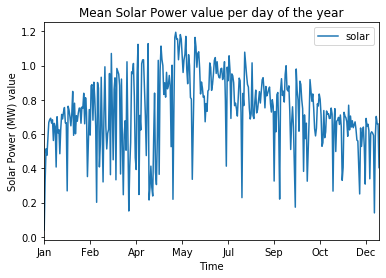

,Month,Day,wind
0,Jan,1,1.199549
1,Jan,2,20.987868
2,Jan,3,5.846778
3,Jan,4,1.699917
4,Jan,5,17.454937
...,...,...,...
360,Dec,27,12.201736
361,Dec,28,10.436250
362,Dec,29,0.338111
363,Dec,30,0.016063


Text(0.5, 1.0, 'Mean Windspeed value per day of the year')

Text(0.5, 0, 'Time')

Text(0, 0.5, 'Windspeed (mph) value')

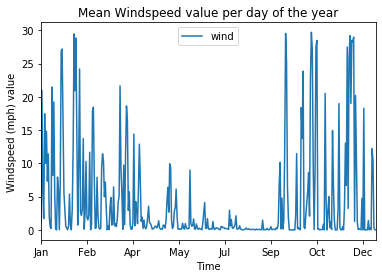

In [24]:
# Plotting mean solar power value per day throughout the year
df4.set_index(['Month','Day']).mean(level=[0,1]).reset_index()
df4.plot(kind='line', x='Month', y='solar')

plt.title('Mean Solar Power value per day of the year')
plt.xlabel("Time")
plt.ylabel("Solar Power (MW) value")
plt.show()

# Plotting mean windspeed value per day throughout the year
df6.set_index(['Month','Day']).mean(level=[0,1]).reset_index()
df6.plot(kind='line', x='Month', y='wind')

plt.title('Mean Windspeed value per day of the year')
plt.xlabel("Time")
plt.ylabel("Windspeed (mph) value")
plt.show()



# Linear Regression model with solar as response variable and wind as predictor variable

## No strong correlation was found between solar and wind data therefore regression modelling between both the parameters was abandoned. 

In [25]:
df1.corr()

,Solar Power (MW),Windspeed (mph)
Solar Power (MW),1.00000,-0.02842
Windspeed (mph),-0.02842,1.00000


### Preprocessing data and creating training and testing data for solar and wind

Time
2019-01-01    0.040694
2019-01-02    0.324306
2019-01-03    0.514097
2019-01-04    0.476528
2019-01-05    0.572778
Name: solar, dtype: float64

Text(0.5, 1.0, 'Solar Train/Test Dataset')

Text(0.5, 0, 'Time')

Text(0, 0.5, 'Solar Power (MW)')

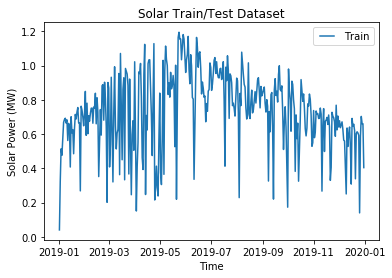

Time
2019-01-01     1.199549
2019-01-02    20.987868
2019-01-03     5.846778
2019-01-04     1.699917
2019-01-05    17.454937
Name: wind, dtype: float64

Text(0.5, 1.0, 'Wind Train/Test Dataset')

Text(0.5, 0, 'Time')

Text(0, 0.5, 'Windspeed (mph)')

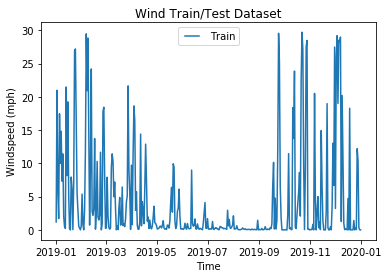

In [26]:
# Function to create predictions based on the testing set and model 
# parameters
def predict(coef, history):
    yhat = coef[0]
    for i in range(1, len(coef)):
        yhat+= coef[i]*history[-i]
    return yhat


series = read_excel('Energy.xlsx', header=0, parse_dates=True, squeeze = True)
series = series.rename(columns = {'Solar Power (MW)':'solar','Windspeed (mph)':'wind'})
series = series.dropna()
series = series.reset_index(drop = True)
series2 = series
series = series.groupby(series['Time'].dt.date).solar.mean()
series2 = series2.groupby(series2['Time'].dt.date).wind.mean()
                        
series.head()
# Create Plot
Train, = plt.plot(series,label = 'Train')

# Add title and axis names
plt.title('Solar Train/Test Dataset')
plt.xlabel('Time')
plt.ylabel('Solar Power (MW)')

# Add legends to plot
plt.legend(handler_map = {Train:HandlerLine2D(numpoints=4)})

# Show Graphic
plt.show()

                        
series2.head()
# Create Plot
Train2, = plt.plot(series2,label = 'Train')

# Add title and axis names
plt.title('Wind Train/Test Dataset')
plt.xlabel('Time')
plt.ylabel('Windspeed (mph)')

# Add legends to plot
plt.legend(handler_map = {Train2:HandlerLine2D(numpoints=4)})

# Show Graphic
plt.show()


## 1. Creating Autoregression model for solar and wind

Test RMSE: 0.193


Text(0.5, 1.0, 'AutoReg Model Model vs Test')

Text(0.5, 0, 'Time (Day of year)')

Text(0, 0.5, 'Solar Power (MW)')

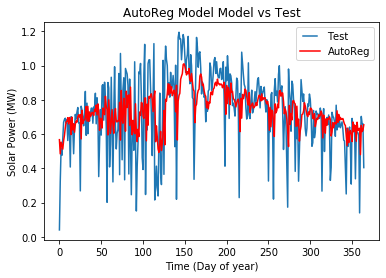

In [27]:
from statsmodels.tsa.ar_model import AutoReg

# Creating numpy array of values stored in series for solar
x = series.values

# Creating training and testing set
train,test = x,x

# train Autoregression model

# Model definition
model = AutoReg(train, lags=6)

# Fitting the model
model_fit = model.fit()

# Creating history based on training set and predictions list
history = [train[i] for i in range(len(train))]
predictions = list()
coef = model_fit.params

# Creating and storing prediction in history and comparing with history to get rmse values for the model
for t in range(len(test)):
    yhat = predict(coef,history)
    obs = test[t]
    predictions.append(yhat)
    history.append(obs)

# Calculating and printing RMSE value of the model    
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

# Plot model values vs test dataset

# Add title and axis names
plt.title('AutoReg Model Model vs Test')
plt.xlabel('Time (Day of year)')
plt.ylabel('Solar Power (MW)')

# Create the required plots
Test, = plt.plot(test, label="Test")
AutoReg, = plt.plot(predictions, color='red',label="AutoReg")

# Add Legends to the plot
plt.legend(handler_map = {Test:HandlerLine2D(numpoints=4)})

# Show graphic
plt.show()

Test RMSE: 6.135


Text(0.5, 1.0, 'AutoReg Model Model vs Test')

Text(0.5, 0, 'Time (Day of year)')

Text(0, 0.5, 'Windspeed (mph)')

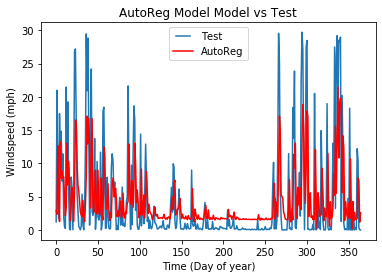

In [28]:
from statsmodels.tsa.ar_model import AutoReg

# Creating numpy array of values stored in series for wind
x = series2.values

# Creating training and testing set
train,test = x,x

# train Autoregression model

# Model definition
model = AutoReg(train, lags=6)

# Fitting the model
model_fit = model.fit()

# Creating history based on training set and predictions list
history = [train[i] for i in range(len(train))]
predictions = list()
coef = model_fit.params

# Creating and storing prediction in history and comparing with history to get rmse values for the model
for t in range(len(test)):
    yhat = predict(coef,history)
    obs = test[t]
    predictions.append(yhat)
    history.append(obs)

# Calculating and printing RMSE value of the model    
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

# Plot model values vs test dataset

# Add title and axis names
plt.title('AutoReg Model Model vs Test')
plt.xlabel('Time (Day of year)')
plt.ylabel('Windspeed (mph)')

# Create the required plots
Test, = plt.plot(test, label="Test")
AutoReg, = plt.plot(predictions, color='red',label="AutoReg")

# Add Legends to the plot
plt.legend(handler_map = {Test:HandlerLine2D(numpoints=4)})

# Show graphic
plt.show()

## 2. Creating Moving Average model for solar and wind

Test RMSE: 0.204


Text(0.5, 1.0, 'Moving Average (MA) Model vs Test')

Text(0.5, 0, 'Time (Day of year)')

Text(0, 0.5, 'Solar Power (MW)')

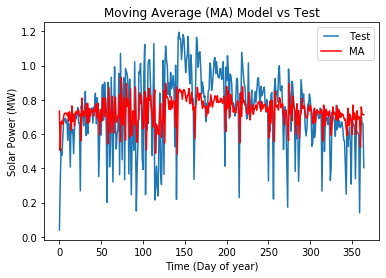

In [29]:
# Creating numpy array of values stored in series for solar
x = series.values

# Creating training and testing set
train,test = x,x

# train Moving Average Model

# Model definition
model = ARMA(train, order = (0,1))

# Fitting the model
model_fit = model.fit(disp = False)

# Creating history based on training set and predictions list
history = [train[i] for i in range(len(train))]
predictions = list()

# Creating and storing prediction in history and comparing with history to get rmse values for the model
for t in range(len(test)):
    yhat = model_fit.predict(t,t)
    obs = test[t]
    predictions.append(yhat)
    history.append(obs)

# Calculating and printing RMSE value of the model    
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

# Plot model values vs test dataset

# Add title and axis names
plt.title('Moving Average (MA) Model vs Test')
plt.xlabel('Time (Day of year)')
plt.ylabel('Solar Power (MW)')

# Create the required plots
Test, = plt.plot(test, label="Test")
AutoReg, = plt.plot(predictions, color='red',label="MA")

# Add Legends to the plot
plt.legend(handler_map = {Test:HandlerLine2D(numpoints=4)})

# Show graphic
plt.show()

Test RMSE: 6.469


Text(0.5, 1.0, 'Moving Average (MA) Model vs Test')

Text(0.5, 0, 'Time (Day of year)')

Text(0, 0.5, 'Windspeed (mph)')

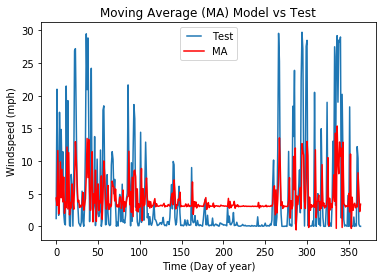

In [30]:
# Creating numpy array of values stored in series for wind
x = series2.values

# Creating training and testing set
train,test = x,x

# train Moving Average Model

# Model definition
model = ARMA(train, order = (0,1))

# Fitting the model
model_fit = model.fit(disp = False)

# Creating history based on training set and predictions list
history = [train[i] for i in range(len(train))]
predictions = list()

# Creating and storing prediction in history and comparing with history to get rmse values for the model
for t in range(len(test)):
    yhat = model_fit.predict(t,t)
    obs = test[t]
    predictions.append(yhat)
    history.append(obs)

# Calculating and printing RMSE value of the model    
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

# Plot model values vs test dataset

# Add title and axis names
plt.title('Moving Average (MA) Model vs Test')
plt.xlabel('Time (Day of year)')
plt.ylabel('Windspeed (mph)')

# Create the required plots
Test, = plt.plot(test, label="Test")
AutoReg, = plt.plot(predictions, color='red',label="MA")

# Add Legends to the plot
plt.legend(handler_map = {Test:HandlerLine2D(numpoints=4)})

# Show graphic
plt.show()

## 3. Creating Autoregressive Moving Average model for solar and wind


Test RMSE: 0.193


Text(0.5, 1.0, 'Autoregressive Moving Average Model (ARMA) vs Test')

Text(0.5, 0, 'Time (Day of year)')

Text(0, 0.5, 'Solar Power (MW)')

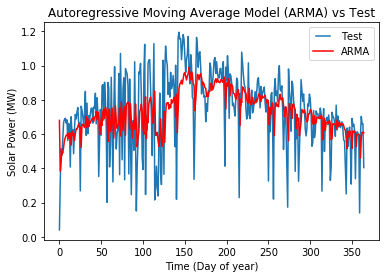

In [31]:
# Creating numpy array of values stored in series for solar
x = series.values

# Creating training and testing set
train,test = x,x

# train Autoregressive Moving Average Model

# Model definition
model = ARMA(train, order = (2,1))

# Fitting the model
model_fit = model.fit(disp = False)

# Creating history based on training set and predictions list
history = [train[i] for i in range(len(train))]
predictions = list()

# Creating and storing prediction in history and comparing with history to get rmse values for the model
for t in range(len(test)):
    yhat = model_fit.predict(t,t)
    obs = test[t]
    predictions.append(yhat)
    history.append(obs)

# Calculating and printing RMSE value of the model    
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

# Plot model values vs test dataset

# Add title and axis names
plt.title('Autoregressive Moving Average Model (ARMA) vs Test')
plt.xlabel('Time (Day of year)')
plt.ylabel('Solar Power (MW)')

# Create the required plots
Test, = plt.plot(test, label="Test")
AutoReg, = plt.plot(predictions, color='red',label="ARMA")

# Add Legends to the plot
plt.legend(handler_map = {Test:HandlerLine2D(numpoints=4)})

# Show graphic
plt.show()

Test RMSE: 6.183


Text(0.5, 1.0, 'Autoregressive Moving Average Model (ARMA) vs Test')

Text(0.5, 0, 'Time (Day of year)')

Text(0, 0.5, 'Windspeed (mph)')

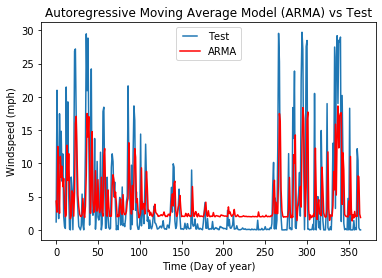

In [32]:
# Creating numpy array of values stored in series for wind
x = series2.values

# Creating training and testing set
train,test = x,x

# train Autoregressive Moving Average Model

# Model definition
model = ARMA(train, order = (2,1))

# Fitting the model
model_fit = model.fit(disp = False)

# Creating history based on training set and predictions list
history = [train[i] for i in range(len(train))]
predictions = list()

# Creating and storing prediction in history and comparing with history to get rmse values for the model
for t in range(len(test)):
    yhat = model_fit.predict(t,t)
    obs = test[t]
    predictions.append(yhat)
    history.append(obs)

# Calculating and printing RMSE value of the model    
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

# Plot model values vs test dataset

# Add title and axis names
plt.title('Autoregressive Moving Average Model (ARMA) vs Test')
plt.xlabel('Time (Day of year)')
plt.ylabel('Windspeed (mph)')

# Create the required plots
Test, = plt.plot(test, label="Test")
AutoReg, = plt.plot(predictions, color='red',label="ARMA")

# Add Legends to the plot
plt.legend(handler_map = {Test:HandlerLine2D(numpoints=4)})

# Show graphic
plt.show()

## 4. Creating Autoregressive Integrated Moving Average model for solar and wind

Test RMSE: 1.281


Text(0.5, 1.0, 'Autoregressive Integrated Moving Average Model (ARIMA) vs Test')

Text(0.5, 0, 'Time (Day of year)')

Text(0, 0.5, 'Solar Power (MW)')

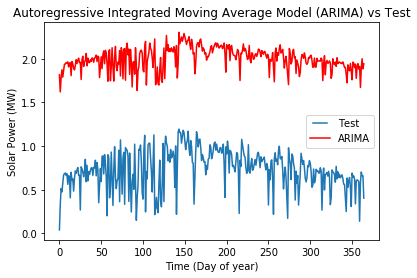

In [41]:
# Creating numpy array of values stored in series for solar
x = series.values

# Creating training and testing set
train,test = x,x

# train Autoregressive Moving Average Model

# Model definition
model = ARIMA(train, order = (1,1,1))

# Fitting the model
model_fit = model.fit(disp = False)

# Creating history based on training set and predictions list
history = [train[i] for i in range(len(train))]
predictions = list()

# Creating and storing prediction in history and comparing with history to get rmse values for the model
for t in range(len(test)):
    yhat = predict(coef,history)
    obs = test[t]
    predictions.append(yhat)
    history.append(obs)

# Calculating and printing RMSE value of the model    
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

# Plot model values vs test dataset

# Add title and axis names
plt.title('Autoregressive Integrated Moving Average Model (ARIMA) vs Test')
plt.xlabel('Time (Day of year)')
plt.ylabel('Solar Power (MW)')

# Create the required plots
Test, = plt.plot(test, label="Test")
AutoReg, = plt.plot(predictions, color='red',label="ARIMA")

# Add Legends to the plot
plt.legend(handler_map = {Test:HandlerLine2D(numpoints=4)})

# Show graphic
plt.show()

Test RMSE: 6.135


Text(0.5, 1.0, 'Autoregressive Integrated Moving Average Model (ARIMA) vs Test')

Text(0.5, 0, 'Time (Day of year)')

Text(0, 0.5, 'Windspeed (mph)')

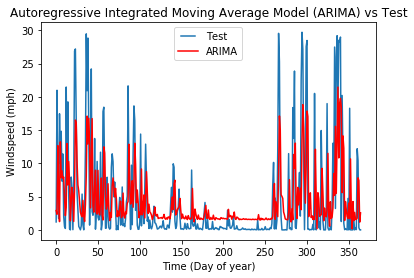

In [34]:
# Creating numpy array of values stored in series for wind
x = series2.values

# Creating training and testing set
train,test = x,x

# train Autoregressive Moving Average Model

# Model definition
model = ARIMA(train, order = (1,1,1))

# Fitting the model
model_fit = model.fit(disp = False)

# Creating history based on training set and predictions list
history = [train[i] for i in range(len(train))]
predictions = list()

# Creating and storing prediction in history and comparing with history to get rmse values for the model
for t in range(len(test)):
    yhat = predict(coef,history)
    obs = test[t]
    predictions.append(yhat)
    history.append(obs)

# Calculating and printing RMSE value of the model    
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

# Plot model values vs test dataset

# Add title and axis names
plt.title('Autoregressive Integrated Moving Average Model (ARIMA) vs Test')
plt.xlabel('Time (Day of year)')
plt.ylabel('Windspeed (mph)')

# Create the required plots
Test, = plt.plot(test, label="Test")
AutoReg, = plt.plot(predictions, color='red',label="ARIMA")

# Add Legends to the plot
plt.legend(handler_map = {Test:HandlerLine2D(numpoints=4)})

# Show graphic
plt.show()

## 5. Creating Seasonal Autoregressive Integrated Moving Average (SARIMA) model for solar and wind

Test RMSE: 0.198


C:\Users\abdul\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Text(0.5, 1.0, 'Seasonal Autoregressive Integrated Moving Average Model (SARIMA) vs Test')

Text(0.5, 0, 'Time (Day of year)')

Text(0, 0.5, 'Solar Power (MW)')

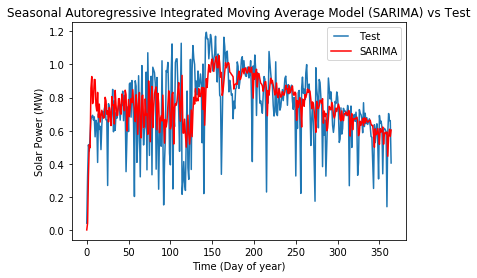

In [35]:
# Creating numpy array of values stored in series for solar
x = series.values

# Creating training and testing set
train,test = x,x

# train Seasonal Autoregressive Integrated Moving Average Model

# Model definition
model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 4))

# Fitting the model
model_fit = model.fit(disp = False)

# Creating history based on training set and predictions list
history = [train[i] for i in range(len(train))]
predictions = list()

# Creating and storing prediction in history and comparing with history to get rmse values for the model
for t in range(len(test)):
    yhat = model_fit.predict(t,t)
    obs = test[t]
    predictions.append(yhat)
    history.append(obs)

# Calculating and printing RMSE value of the model    
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

# Plot model values vs test dataset

# Add title and axis names
plt.title('Seasonal Autoregressive Integrated Moving Average Model (SARIMA) vs Test')
plt.xlabel('Time (Day of year)')
plt.ylabel('Solar Power (MW)')

# Create the required plots
Test, = plt.plot(test, label="Test")
AutoReg, = plt.plot(predictions, color='red',label="SARIMA")

# Add Legends to the plot
plt.legend(handler_map = {Test:HandlerLine2D(numpoints=4)})

# Show graphic
plt.show()

Test RMSE: 6.671


Text(0.5, 1.0, 'Seasonal Autoregressive Integrated Moving Average Model (SARIMA) vs Test')

Text(0.5, 0, 'Time (Day of year)')

Text(0, 0.5, 'Windspeed (mph)')

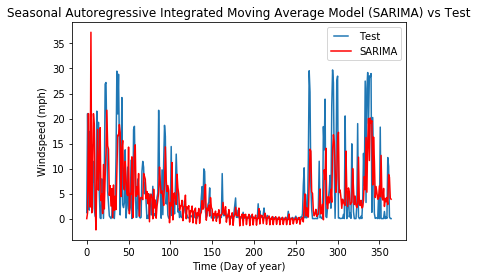

In [36]:
# Creating numpy array of values stored in series for wind
x = series2.values

# Creating training and testing set
train,test = x,x

# train Seasonal Autoregressive Integrated Moving Average Model

# Model definition
model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 4))

# Fitting the model
model_fit = model.fit(disp = False)

# Creating history based on training set and predictions list
history = [train[i] for i in range(len(train))]
predictions = list()

# Creating and storing prediction in history and comparing with history to get rmse values for the model
for t in range(len(test)):
    yhat = model_fit.predict(t,t)
    obs = test[t]
    predictions.append(yhat)
    history.append(obs)

# Calculating and printing RMSE value of the model    
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

# Plot model values vs test dataset

# Add title and axis names
plt.title('Seasonal Autoregressive Integrated Moving Average Model (SARIMA) vs Test')
plt.xlabel('Time (Day of year)')
plt.ylabel('Windspeed (mph)')

# Create the required plots
Test, = plt.plot(test, label="Test")
AutoReg, = plt.plot(predictions, color='red',label="SARIMA")

# Add Legends to the plot
plt.legend(handler_map = {Test:HandlerLine2D(numpoints=4)})

# Show graphic
plt.show()

## 6. Creating Simple Exponential Smoothing model for solar and wind

C:\Users\abdul\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub


Test RMSE: 0.197


Text(0.5, 1.0, 'Simple Exponential Smoothing Model (SES) vs Test')

Text(0.5, 0, 'Time (Day of year)')

Text(0, 0.5, 'Solar Power (MW)')

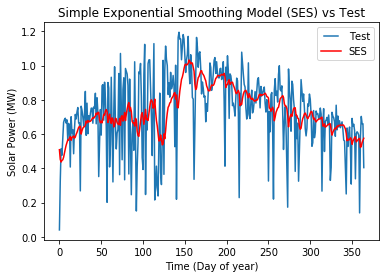

In [37]:
# Creating numpy array of values stored in series for solar
x = series.values

# Creating training and testing set
train,test = x,x

# train Simple Exponential Smoothing Model

# Model definition
model = SimpleExpSmoothing(train)

# Fitting the model
model_fit = model.fit()

# Creating history based on training set and predictions list
history = [train[i] for i in range(len(train))]
predictions = list()

# Creating and storing prediction in history and comparing with history to get rmse values for the model
for t in range(len(test)):
    yhat = model_fit.predict(t,t)
    obs = test[t]
    predictions.append(yhat)
    history.append(obs)

# Calculating and printing RMSE value of the model    
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

# Plot model values vs test dataset

# Add title and axis names
plt.title('Simple Exponential Smoothing Model (SES) vs Test')
plt.xlabel('Time (Day of year)')
plt.ylabel('Solar Power (MW)')

# Create the required plots
Test, = plt.plot(test, label="Test")
AutoReg, = plt.plot(predictions, color='red',label="SES")

# Add Legends to the plot
plt.legend(handler_map = {Test:HandlerLine2D(numpoints=4)})

# Show graphic
plt.show()

C:\Users\abdul\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub


Test RMSE: 6.555


Text(0.5, 1.0, 'Simple Exponential Smoothing Model (SES) vs Test')

Text(0.5, 0, 'Time (Day of year)')

Text(0, 0.5, 'Windspeed (mph)')

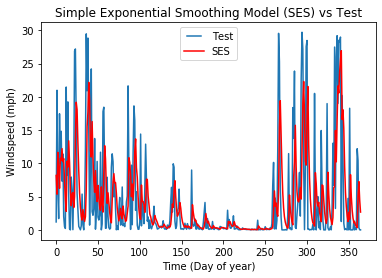

In [38]:
# Creating numpy array of values stored in series for wind
x = series2.values

# Creating training and testing set
train,test = x,x

# train Simple Exponential Smoothing Model

# Model definition
model = SimpleExpSmoothing(train)

# Fitting the model
model_fit = model.fit()

# Creating history based on training set and predictions list
history = [train[i] for i in range(len(train))]
predictions = list()

# Creating and storing prediction in history and comparing with history to get rmse values for the model
for t in range(len(test)):
    yhat = model_fit.predict(t,t)
    obs = test[t]
    predictions.append(yhat)
    history.append(obs)

# Calculating and printing RMSE value of the model    
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

# Plot model values vs test dataset

# Add title and axis names
plt.title('Simple Exponential Smoothing Model (SES) vs Test')
plt.xlabel('Time (Day of year)')
plt.ylabel('Windspeed (mph)')

# Create the required plots
Test, = plt.plot(test, label="Test")
AutoReg, = plt.plot(predictions, color='red',label="SES")

# Add Legends to the plot
plt.legend(handler_map = {Test:HandlerLine2D(numpoints=4)})

# Show graphic
plt.show()

## 7. Creating Holt Winter's Exponential Smoothing (HWES) model for solar and wind

C:\Users\abdul\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub


Test RMSE: 0.197


Text(0.5, 1.0, 'Exponential Smoothing Model (HWES) vs Test')

Text(0.5, 0, 'Time (Day of year)')

Text(0, 0.5, 'Solar Power (MW)')

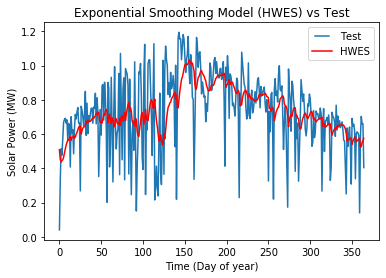

In [39]:
# Creating numpy array of values stored in series for solar
x = series.values

# Creating training and testing set
train,test = x,x

# train Holt Winter's Exponential Smoothing Model

# Model definition
model = ExponentialSmoothing(train)

# Fitting the model
model_fit = model.fit()

# Creating history based on training set and predictions list
history = [train[i] for i in range(len(train))]
predictions = list()

# Creating and storing prediction in history and comparing with history to get rmse values for the model
for t in range(len(test)):
    yhat = model_fit.predict(t,t)
    obs = test[t]
    predictions.append(yhat)
    history.append(obs)

# Calculating and printing RMSE value of the model    
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

# Plot model values vs test dataset

# Add title and axis names
plt.title('Exponential Smoothing Model (HWES) vs Test')
plt.xlabel('Time (Day of year)')
plt.ylabel('Solar Power (MW)')

# Create the required plots
Test, = plt.plot(test, label="Test")
AutoReg, = plt.plot(predictions, color='red',label="HWES")

# Add Legends to the plot
plt.legend(handler_map = {Test:HandlerLine2D(numpoints=4)})

# Show graphic
plt.show()

C:\Users\abdul\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub


Test RMSE: 6.555


Text(0.5, 1.0, 'Exponential Smoothing Model (HWES) vs Test')

Text(0.5, 0, 'Time (Day of year)')

Text(0, 0.5, 'Windspeed (mph)')

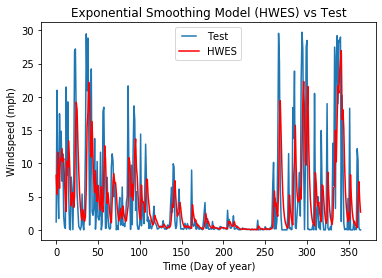

In [40]:
# Creating numpy array of values stored in series for wind
x = series2.values

# Creating training and testing set
train,test = x,x

# train Holt Winter's Exponential Smoothing Model

# Model definition
model = ExponentialSmoothing(train)

# Fitting the model
model_fit = model.fit()

# Creating history based on training set and predictions list
history = [train[i] for i in range(len(train))]
predictions = list()

# Creating and storing prediction in history and comparing with history to get rmse values for the model
for t in range(len(test)):
    yhat = model_fit.predict(t,t)
    obs = test[t]
    predictions.append(yhat)
    history.append(obs)

# Calculating and printing RMSE value of the model    
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

# Plot model values vs test dataset

# Add title and axis names
plt.title('Exponential Smoothing Model (HWES) vs Test')
plt.xlabel('Time (Day of year)')
plt.ylabel('Windspeed (mph)')

# Create the required plots
Test, = plt.plot(test, label="Test")
AutoReg, = plt.plot(predictions, color='red',label="HWES")

# Add Legends to the plot
plt.legend(handler_map = {Test:HandlerLine2D(numpoints=4)})

# Show graphic
plt.show()